<a href="https://colab.research.google.com/github/Ahmed-naeem-10/firstgit/blob/main/tumor_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
img_dir = " /content/extracted_data"

In [ ]:
from PIL import Image,ImageEnhance
import random
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import  load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir ='/content/drive/MyDrive/MRI/Training'
test_dir = '/content/drive/MyDrive/MRI/Testing'

train_path = []
train_label = []
for label in os.listdir(train_dir):
  for img in os.listdir(os.path.join(train_dir,label)):
    train_path.append(os.path.join(train_dir,label,img))
    train_label.append(label)

train_path,train_label = shuffle(train_path,train_label)

test_path = []
test_label = []
for label in os.listdir(test_dir):
  for img in os.listdir(os.path.join(test_dir,label)):
    test_path.append(os.path.join(test_dir,label,img))
    test_label.append(label)

test_path,test_label = shuffle(test_path,test_label)

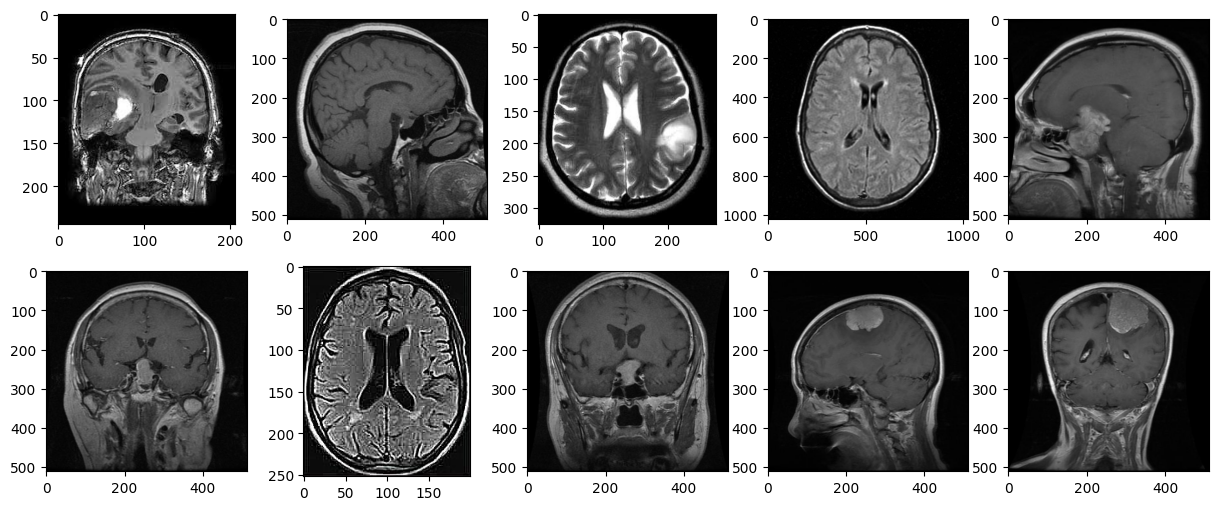

In [ ]:
import matplotlib.pyplot as plt
random_indices = random.sample(range(len(train_path)), 10)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i, index in enumerate(random_indices):
    img = load_img(train_path[index])
    axes[i].imshow(img, cmap='gray')

In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMAGE_SIZE = 128  # Define IMAGE_SIZE

# Data Augmentation
def augment(image):
    image = Image.fromarray(np.uint8(image))  # Convert to PIL
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0  # Normalize
    return image

# Load and preprocess image
def open_image(paths):
    images = []
    for path in paths:
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Load as PIL
        img = img_to_array(img)  # Convert to NumPy array
        img = augment(img)  # Apply augmentation
        images.append(img)
    return np.array(images)  # Convert to NumPy array

# Encode labels correctly
def encode_label(label):
    unique_labels = sorted(os.listdir(train_dir))  # Ensure consistent ordering
    return np.array([unique_labels.index(lbl) for lbl in label])  # Encode batch labels

# Data generator
def datagen(path, label, batch_size=12, epochs=1):
    path = np.array(path)  # Ensure it's an array
    label = np.array(label)  # Ensure it's an array

    for _ in range(epochs):
        indices = np.arange(len(path))  # Create indices
        np.random.shuffle(indices)  # Shuffle the dataset

        path = path[indices]  # Shuffle image paths
        label = label[indices]  # Shuffle labels

        for i in range(0, len(path), batch_size):
            batch_path = path[i:i+batch_size]
            batch_images = open_image(batch_path)  # Load and augment images
            batch_label = label[i:i+batch_size]
            batch_label = encode_label(batch_label)  # Encode labels

            yield batch_images, batch_label  # Ensure tuple output


In [ ]:
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(128,activation='relu'))
model.add(Dense(len(os.listdir(train_dir)),activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
batch_size = 20
steps = int(len(train_path)/ batch_size)
epochs = 5

history = model.fit(
    datagen(train_path, train_label, batch_size= batch_size, epochs=epochs),
    steps_per_epoch=steps,  # Ensure correct steps
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
285/285 ━━━━━━━━━━━━━━━━━━━━ 1457s 5s/step - loss: 0.6435 - sparse_categorical_accuracy: 0.7387


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import numpy as np
test_images= open_image(test_path)
test_labels = encode_label(test_label)
test_prediction = model.predict(test_images)
print("Classification Report:")
print(classification_report(test_labels, np.argmax(test_prediction, axis=1)))

42/42 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       310
           1       0.77      0.72      0.74       306
           2       0.89      0.98      0.93       405
           3       0.97      0.90      0.94       300

    accuracy                           0.87      1321
   macro avg       0.87      0.86      0.86      1321
weighted avg       0.87      0.87      0.87      1321



In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
class_label= ['pituitary', 'glioma','notumor','meninglioma']
def detect_and_display(image_path,model):
  try:
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = model.predict(img_array)
    prediction_class_index = np.argmax(prediction)
    confidence_score = np.max(prediction,axis=1)[0]
    if class_labels[prediction_class_index] == 'notumor':
      return '  No Tumor'
    else:
      result = f"Tumor {class_label[prediction_class_index]}"
  except Exception as e:
    print("Error processing the image:", str(e))

